A notebook for making a 100-frame movie from 3D dust for Linnea as a test

Two environment variables need to be set in bash: DROPBOX_ROOT, and FFMPEG_ROOT. The DROPBOX_ROOT folder is the path to the top level directory of the dust-holgrams folder shared by Josh. E.g. in bash,

export DROPBOX_ROOT='/Users/catherinezucker/Dropbox/dust-holograms/'

You can also set the path to the FFMPEG executable:

export FFMPEG_PATH='/usr/local/bin'

Ideally, you would set these in your bash_profile profile  (now called zprofile in the latest OS operating systems). Alternatively, if you want to set one of these variables locally in this notebook, you can use:

```
import os
os.environ['DROPBOX_ROOT'] = '/Users/catherinezucker/Dropbox/dust-holograms'
os.environ['FFMPEG_ROOT'] = '/Usr/local/bin'

```

First thing we need to do is figure out how to write some json

In [1]:
import json
import numpy as np
import os
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt
from astropy import table

Josh is having some trouble with ```.zprofile``` so:

In [2]:
if (os.environ.keys() != 'DROPBOX_HOME'):
    os.environ['DROPBOX_ROOT'] = '/Users/jegpeek/Dropbox/dust-holograms'
    os.environ['FFMPEG_ROOT'] = '/Users/jegpeek/'

Using a variable called ```run_name``` to record everything we need about the run

In [3]:
def define_paths(run_name):
    if os.path.isdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name)) == False:
        os.mkdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name))
        os.mkdir("{}/{}/frames/".format(os.environ['DROPBOX_ROOT'],run_name))

This is the camera properties, which we will fix.

In [4]:
arc = False
if arc:
    ec = "szyz"
if not arc:
    ec = "rxyz"

t = True
cprops ={
    "projection": "stereographic",
    "step_size": 1,
    "max_dist": 500.0,
    "fov": 45.0,
    "x_pix": 60,
    "y_pix": 40,
    "vmax": "auto",
    "clip_mode": "tanh",
    "fuzzy": t,
    "randomize_angles": t,
    "euler_convention": ec}

In [5]:
print(cprops)

{'projection': 'stereographic', 'step_size': 1, 'max_dist': 500.0, 'fov': 45.0, 'x_pix': 60, 'y_pix': 40, 'vmax': 'auto', 'clip_mode': 'tanh', 'fuzzy': True, 'randomize_angles': True, 'euler_convention': 'rxyz'}


_In arc mode_ Linnea asked for 100 frames orbiting around a point with equal distance. We'll assume that the middle of these 100 frames is the Sun, and we'll set some sweep out angle in the Galactic Plane.

In [6]:
nframes = 19 # 100 frames
if arc:
    angle_sweep = 45 # half of this CCW and half CW from the sun

In [7]:
def sweep(xc, yc, angle_sweep, nframes):
    R = np.sqrt(xc**2+ yc**2)
    phi =np.arctan2(yc, xc)*180/np.pi
    dangs = np.linspace(0, angle_sweep, nframes)
    xs = xc - R*np.cos((phi-angle_sweep/2+dangs)*np.pi/180)
    ys = yc - R*np.sin((phi-angle_sweep/2+dangs)*np.pi/180)
    angs = (dangs-angle_sweep/2+phi)*np.pi/180 ## wait are these in RADIANs??
    return xs, ys, angs

In [8]:
def plot_ang(x0, y0, xs, ys, run_name):
    plt.figure(figsize=[5, 5])
    plt.scatter(x0, y0)
    plt.scatter(0, 0, c='red')
    plt.plot(xs, ys)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title(run_name)
    plt.savefig('{}/{}/arc_{}'.format(os.environ['DROPBOX_ROOT'],run_name,run_name))

In [9]:
def plot_track(xts, yts, xc, yc, run_name):
    plt.figure(figsize=[5, 5])
    plt.scatter(xts, yts)
    plt.scatter(0, 0, c='C1')
    plt.scatter(xc, yc, c='C2')
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title(run_name)
    plt.savefig('{}/{}/arc_{}'.format(os.environ['DROPBOX_ROOT'],run_name,run_name))

In track mode we'll move from one point to another while pointing at the cloud and keeping to top of the camera perpindicular to the plane that contains the track and cloud

Given the current position of the viewer, the unit direction toward the start of the track, and the cloud position, compute the angles of rotation

In [10]:
def determine_angles(v_pos, c_pos, t_hat):
    x_hat = np.array([1, 0, 0])
    y_hat = np.array([0, 1, 0])
    z_hat = np.array([0, 0, 1])
    # the vector to the cloud
    c_vec = c_pos-v_pos
    # the unit vector toward the cloud
    c_hat = c_vec/np.sqrt(np.sum(c_vec**2))
    
    #FIRST
    # the unit vector perp to the plane containing the track and the cloud
    n_OCT = np.cross(c_hat, t_hat) #CHECK ORDER ####FLIPPED
    n_hat_OCT = n_OCT/np.sqrt(np.sum(n_OCT**2))
    #print('n_hat_OCT', n_hat_OCT)
    #print('c_hat', c_hat)
    #print('v_pos', v_pos)
    #print('c_vec', c_vec)
    #print('c_pos', c_pos)
    # find the new orientation of the side of the camera
    v_y_prime = np.cross(n_hat_OCT, x_hat) #CHECK ORDER (correct)
    v_hat_y_prime = v_y_prime/np.sqrt(np.sum(v_y_prime**2))
    # and find the angle to rotate first
    theta = np.arccos(np.dot(v_hat_y_prime,y_hat))
    #print('theta', theta)
    #print('v_hat_y_prime',v_hat_y_prime)
    
    #SECOND
    # the unit vector perp to the plane that contains the rotation 
    #n_phi = np.cross(v_hat_y_prime, x_hat) #CHECK ORDER ###FLIPPED
    #n_hat_phi = n_phi/np.sqrt(np.sum(n_phi**2))
    # the vector being rotated to
    #v_x_prime_prime = np.cross(n_hat_OCT,n_hat_phi) #CHECK ORDER (correct)
    #### OOOPS
    v_x_prime_prime = np.cross(v_hat_y_prime, n_hat_OCT)
    v_hat_x_prime_prime = v_x_prime_prime/np.sqrt(np.sum(v_x_prime_prime**2))
    # and the angle rotated
    phi = np.arccos(np.dot(v_hat_x_prime_prime, x_hat))
    #print('n_phi', n_phi)
    
    #FINALLY
    zeta = np.arccos(np.dot(v_hat_x_prime_prime, c_hat))
    print('c hat', c_hat)
    return theta, phi, zeta
    

given some inputs build a track

In [11]:
def track(xt1, yt1, zt1, xt2, yt2, zt2, nframes):
    xts = np.linspace(xt1, xt2, nframes)
    yts = np.linspace(yt1, yt2, nframes)
    zts = np.linspace(zt1, zt2, nframes)
    t_vec = np.array([xt2-xt1, yt2-yt1, zt2-zt1])
    t_hat = t_vec/np.sqrt(np.sum(t_vec**2))
    return xts, yts, zts, t_hat

In [12]:
def build_fprops(fprops, cprops, angs, xs, ys, zc):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zc],
          "angles": [angs[i], 0.0, 0.0]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

In [13]:
def build_fprops_track(fprops, cprops, theatas, phis, zetas, xs, ys, zs):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zs[i]],
          "angles": [thetas[i], phis[i], zetas[i]]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

Let's read in a list of molecular clouds and make movies for each one:

In [14]:
clouds = table.Table.read('{}/Holo_Cloud_Targets.csv'.format(os.environ['DROPBOX_ROOT']))
#clouds = table.Table.read('{}/Holo_TEST_Targets.csv'.format(os.environ['DROPBOX_ROOT']))

Chamaeleon
[0.87415728 0.48564293 0.        ]
c hat [ 0.79961764 -0.54710681 -0.24755964]
14.021279827756612 7.666008811742404 36.21277000968203 36.21277000968203
c hat [ 0.77291301 -0.58207029 -0.25258595]
14.021279827756612 7.666008811742404 38.75011723401205 2.537347224330018
c hat [ 0.74355323 -0.61719778 -0.25728485]
14.021279827756612 7.666008811742404 41.38721154991796 2.6370943159059017
c hat [ 0.71148843 -0.65219773 -0.26157663]
14.021279827756612 7.666008811742355 44.118241938244594 2.7310303883266402
c hat [ 0.67672133 -0.68674683 -0.26538091]
14.021279827756612 7.666008811742404 46.93527873071644 2.817036792471846
c hat [ 0.63931583 -0.72049879 -0.2686201 ]
14.021279827756612 7.666008811742404 49.82823348409732 2.892954753380875
c hat [ 0.59940312 -0.75309622 -0.27122313]
14.021279827756612 7.666008811742404 52.7849310296664 2.9566975455690936
c hat [ 0.5571841  -0.78418504 -0.27312946]
14.021279827756612 7.666008811742355 55.79130832473395 3.006377295067542
c hat [ 0.51292

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.005763262931589452
frame 1: vmax = 0.012605829434067345
frame 2: vmax = 0.011255962971772534
frame 3: vmax = 0.015025173014276335
frame 4: vmax = 0.017588822412866648
frame 5: vmax = 0.015981217493365875
frame 6: vmax = 0.019509667440113846
frame 7: vmax = 0.018102026558721264
frame 8: vmax = 0.022128149835483783
frame 9: vmax = 0.027138319544490516
frame 10: vmax = 0.02498811478809512
frame 11: vmax = 0.02208868067401636
frame 12: vmax = 0.025449281264998718
frame 13: vmax = 0.017484497035591632
frame 14: vmax = 0.01901554363028845
frame 15: vmax = 0.013242336853189044
frame 16: vmax = 0.012228149335052877
frame 17: vmax = 0.011546981842813693
frame 18: vmax = 0.011757958156864333
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Ophiuchus
[0.07728751 0.99700885 0.        ]
c hat [0.89438236 0.36375999 0.26030531]
1.3345267899114428 16.722273735393927 20.952807428524604 -66.61341459226995
c hat [0.90862956 0.32229491 0.26555285]
1.3345267899114428 16.722273735393927 18.422571877184208 -2.530235551340394
c hat [0.92155562 0.27854712 0.27045654]
1.3345267899114428 16.722273735393927 15.793595759785687 -2.628976117398521
c hat [0.93289439 0.23263613 0.27493361]
1.3345267899114428 16.722273735393927 13.071681291663333 -2.721914468122353
c hat [0.94238251 0.18474193 0.27890073]
1.3345267899114428 16.722273735393905 10.264716266008953 -2.806965025654379
c hat [0.94977127 0.13510718 0.28227749]
1.3345267899114428 16.722273735393927 7.382710613442561 -2.8820056525663937
c hat [0.95483952 0.08403562 0.28499037]
1.3345267899114428 16.722273735393927 4.437723120093873 -2.944987493348688
c hat [0.95740671 0.0318863  0.28697674]
1.3345267899114428 16.722273735393927 1.4436643277933123 -2.9940587923005606
c hat [ 0.95734473 

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.0200683602590434
frame 1: vmax = 0.018130516095567147
frame 2: vmax = 0.020387991161682294
frame 3: vmax = 0.02202932858360873
frame 4: vmax = 0.025123848647795967
frame 5: vmax = 0.023492060748612858
frame 6: vmax = 0.01870949172702967
frame 7: vmax = 0.027722646192778484
frame 8: vmax = 0.03242279275637702
frame 9: vmax = 0.028071834617792776
frame 10: vmax = 0.01897816831454111
frame 11: vmax = 0.029473475300110297
frame 12: vmax = 0.01730674484395422
frame 13: vmax = 0.01881063885256299
frame 14: vmax = 0.029612419236669667
frame 15: vmax = 0.02134305651692557
frame 16: vmax = 0.027834479607219693
frame 17: vmax = 0.01995578054538055
frame 18: vmax = 0.020138889039168134
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Lupus
[0.31073886 0.95049533 0.        ]
c hat [0.9862492  0.14671476 0.07607432]
1.5183431674659535 4.63367169723601 8.316867457223637 -21.8935761205926
c hat [0.99176816 0.10176726 0.07771318]
1.5183431674659535 4.63367169723601 5.720303789995239 -2.596563667228396
c hat [0.99535168 0.05472076 0.07925075]
1.5183431674659535 4.63367169723601 3.015243370835808 -2.7050604191594316
c hat [0.99672504 0.00576142 0.08065983]
1.5183431674659535 4.63367169723601 0.20753442775173822 -2.8077089430840703
c hat [ 0.99562953 -0.04485696  0.08191271]
1.5183431674659535 4.63367169723601 2.694562443737995 2.4870280159862572
c hat [ 0.99183729 -0.0968128   0.0829824 ]
1.5183431674659535 4.63367169723601 5.680298887872312 2.9857364441343166
c hat [ 0.98516683 -0.1497214   0.08384399]
1.5183431674659535 4.63367169723601 8.736496697277083 3.0561978094047713
c hat [ 0.97549779 -0.2031449   0.0844761 ]
1.5183431674659535 4.63367169723601 11.847760149677622 3.111263452400539
c hat [ 0.96278296 -0.25660742  

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.01550173884382093
frame 1: vmax = 0.01809479836349783
frame 2: vmax = 0.014705470074615732
frame 3: vmax = 0.01436174417359871
frame 4: vmax = 0.02102997994665202
frame 5: vmax = 0.01995443715932197
frame 6: vmax = 0.015909485546813814
frame 7: vmax = 0.02343980437740538
frame 8: vmax = 0.02914945728784369
frame 9: vmax = 0.026539367617238897
frame 10: vmax = 0.020856871392148604
frame 11: vmax = 0.029611927365956945
frame 12: vmax = 0.02609441915593925
frame 13: vmax = 0.021234255496470723
frame 14: vmax = 0.02646098875718599
frame 15: vmax = 0.02431684936535021
frame 16: vmax = 0.03282768843956001
frame 17: vmax = 0.02014119965102873
frame 18: vmax = 0.02912501913777669
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Taurus
[-0.12663189 -0.99194978  0.        ]
c hat [-0.91665998 -0.32083099 -0.2383316 ]
1.989876990334243 15.216125987836898 161.798369291267 117.15110891115411
c hat [-0.92912721 -0.2785303  -0.24319437]
1.989876990334243 15.21612598783692 164.3406170739721 2.5422477827050924
c hat [-0.94014798 -0.23397827 -0.2477417 ]
1.989876990334243 15.21612598783692 166.98331089793115 2.642693823959051
c hat [-0.94945472 -0.18730739 -0.25189615]
1.989876990334243 15.21612598783692 169.72063418052412 2.7373232825929525
c hat [-0.95678526 -0.13871202 -0.25557962]
1.989876990334243 15.21612598783692 172.5446286347631 2.8239944542390023
c hat [-0.96189515 -0.08845013 -0.25871663]
1.989876990334243 15.21612598783692 175.4451516087226 2.90052297395948
c hat [-0.96457111 -0.03684126 -0.26123801]
1.989876990334243 15.21612598783692 178.4099472330367 2.964795624314129
c hat [-0.9646443   0.01574012 -0.26308481]
1.989876990334243 15.21612598783692 178.57515353387984 0.16520630084313592
c hat [-0.96200219 

: 73.9% 20.4%  5.7%
[libx264 @ 0x7feb9f505180] ref B L1: 86.0% 14.0%
[libx264 @ 0x7feb9f505180] kb/s:742.40


Loaded specifications for 19 images.


100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.009479496123411082
frame 1: vmax = 0.013372791571855487
frame 2: vmax = 0.016132797096192007
frame 3: vmax = 0.010784964685411978
frame 4: vmax = 0.009357609553146176
frame 5: vmax = 0.011966658602139432
frame 6: vmax = 0.010526282125078069
frame 7: vmax = 0.014790587235773273
frame 8: vmax = 0.01385853639238303
frame 9: vmax = 0.015031095649415875
frame 10: vmax = 0.011821122851053589
frame 11: vmax = 0.01152644932882322
frame 12: vmax = 0.014567801551183947
frame 13: vmax = 0.017374795575764438
frame 14: vmax = 0.0123061719012112
frame 15: vmax = 0.009450615596902936
frame 16: vmax = 0.010070869947052415
frame 17: vmax = 0.01199614651587035
frame 18: vmax = 0.010782095667671457
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Perseus
[-0.3582515  -0.93362512  0.        ]
c hat [-0.94600944 -0.0922936  -0.3107218 ]
7.459696764127394 18.692816955761153 177.06678808616883 30.35006378443688
c hat [-0.94722315 -0.04913851 -0.31678655]
7.459696764127394 18.69281695576117 179.56485628023387 2.4980681940650467
c hat [-0.94657915 -0.00425668 -0.32244349]
7.459696764127394 18.692816955761153 177.8427750667797 -1.7220812134541792
c hat [-0.94387535  0.04216625 -0.32759935]
7.459696764127394 18.692816955761153 175.16185815661592 -2.6809169101637558
c hat [-0.93892957  0.08989168 -0.33216072]
7.459696764127394 18.69281695576117 172.4000867521458 -2.761771404470133
c hat [-0.93159025  0.1386295  -0.33603791]
7.459696764127394 18.69281695576117 169.56711816593247 -2.8329685862133336
c hat [-0.92174705  0.18804311 -0.33914919]
7.459696764127394 18.692816955761153 166.67449545142165 -2.8926227145108303
c hat [-0.90934037  0.23775814 -0.34142519]
7.459696764127394 18.69281695576117 163.73545846656268 -2.939036984858961
c hat

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.0066896827479649805
frame 1: vmax = 0.010492548707559763
frame 2: vmax = 0.010605920772897662
frame 3: vmax = 0.013349618003798242
frame 4: vmax = 0.009107164954064502
frame 5: vmax = 0.008065080547457911
frame 6: vmax = 0.011219462076680429
frame 7: vmax = 0.007649982867491417
frame 8: vmax = 0.011291032928880668
frame 9: vmax = 0.01662344806085457
frame 10: vmax = 0.01438167224294375
frame 11: vmax = 0.009169664184239082
frame 12: vmax = 0.011090061077757127
frame 13: vmax = 0.01095847658873754
frame 14: vmax = 0.009827804898994145
frame 15: vmax = 0.008188617523217544
frame 16: vmax = 0.01119140003593202
frame 17: vmax = 0.008940074234847998
frame 18: vmax = 0.01200940749233996
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Musca
[0.85749293 0.51449576 0.        ]
c hat [ 0.83455826 -0.53108253 -0.14650552]
8.08128460438462 4.821298199070023 33.12066790338364 -99.50147870145769
c hat [ 0.80920182 -0.56816298 -0.14961031]
8.08128460438462 4.821298199070023 35.700817959839924 2.5801500564562834
c hat [ 0.78106122 -0.60554185 -0.15252029]
8.08128460438462 4.821298199070023 38.386971804392374 2.6861538445524573
c hat [ 0.75005859 -0.64290736 -0.15518454]
8.08128460438462 4.821298199070023 41.1732846361977 2.7863128318053216
c hat [ 0.71617106 -0.67990924 -0.15755138]
8.081284604384576 4.821298199070023 44.0515840778228 2.878299441625097
c hat [ 0.67944142 -0.71616799 -0.15957059]
8.08128460438462 4.821298199070023 47.0113056256742 2.9597215478514003
c hat [ 0.63998609 -0.75128802 -0.1611959 ]
8.08128460438462 4.821298199070023 50.03955523414622 3.028249608472024
c hat [ 0.59799922 -0.78487398 -0.16238772]
8.08128460438462 4.821298199070023 53.1213181476744 3.0817629135281783
c hat [ 0.55375167 -0.81654907 -0.

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.006349526922045698
frame 1: vmax = 0.010119353025987949
frame 2: vmax = 0.010016484078205394
frame 3: vmax = 0.012691164607644169
frame 4: vmax = 0.01600145835510557
frame 5: vmax = 0.0180604665658193
frame 6: vmax = 0.012772000256798493
frame 7: vmax = 0.01625269567265423
frame 8: vmax = 0.02240977462535011
frame 9: vmax = 0.018058634471984986
frame 10: vmax = 0.023240566179891176
frame 11: vmax = 0.02481926282060158
frame 12: vmax = 0.02134191413311055
frame 13: vmax = 0.036405945749284005
frame 14: vmax = 0.015890226576302666
frame 15: vmax = 0.017563832944244497
frame 16: vmax = 0.011895269231405109
frame 17: vmax = 0.015615629662082938
frame 18: vmax = 0.011912202006700682
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Pipe
[-0.03309444  0.99945223  0.        ]
c hat [0.87760041 0.47573625 0.05909767]
0.12550531822160205 3.7847431394564848 28.415656490685624 -57.217712452600864
c hat [0.89822855 0.43536246 0.06037384]
0.12550531822160205 3.7847431394564848 25.816710398254067 -2.5989460924315586
c hat [0.91775461 0.39234608 0.06157131]
0.12550531822160205 3.7847431394564848 23.108901236871805 -2.707809161382264
c hat [0.93585509 0.34676773 0.06266887]
0.12550531822160205 3.7847431394564848 20.298077257144744 -2.810823979727057
c hat [0.9521982  0.29877738 0.06364489]
0.12550531822160205 3.7847431394564848 17.39251160767566 -2.9055656494690836
c hat [0.96645785 0.24859961 0.06447829]
0.12550531822160205 3.7847431394564848 14.402979375786105 -2.989532231889559
c hat [0.97833003 0.19653467 0.06514961]
0.12550531822160205 3.7847431394564848 11.342700411005392 -3.060278964780711
c hat [0.98755012 0.14295408 0.06564218]
0.12550531822160205 3.7847431394564848 8.227126497702693 -3.1155739133026996
c hat [0.99

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.020471332460598207
frame 1: vmax = 0.022232751445786562
frame 2: vmax = 0.016284407732266117
frame 3: vmax = 0.018917995213210817
frame 4: vmax = 0.01856960988645733
frame 5: vmax = 0.023106332667754033
frame 6: vmax = 0.025426262016771943
frame 7: vmax = 0.015887013945597574
frame 8: vmax = 0.02779750918586797
frame 9: vmax = 0.030002041260468106
frame 10: vmax = 0.030688934963771317
frame 11: vmax = 0.013952258464501937
frame 12: vmax = 0.022672691323576147
frame 13: vmax = 0.018096364526456455
frame 14: vmax = 0.0322134429228754
frame 15: vmax = 0.02158729381131707
frame 16: vmax = 0.03248073787067551
frame 17: vmax = 0.02719533442152897
frame 18: vmax = 0.023680449272345867
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Cepheus
[-0.92722167 -0.37451299  0.        ]
c hat [-0.72658109  0.64148601  0.24612116]
14.748116317219779 5.870699571047848 136.920937323917 112.3066108668834
c hat [-0.69578055  0.67292428  0.25112216]
14.748116317219779 5.870699571047848 134.38281255496662 -2.5381247689503716
c hat [-0.66232232  0.70419935  0.25579762]
14.748116317219779 5.870699571047848 131.7448300894037 -2.6379824655629265
c hat [-0.62619248  0.73501533  0.26006816]
14.748116317219779 5.870699571047848 129.01280185679224 -2.732028232611456
c hat [-0.5874333   0.76505118  0.26385377]
14.748116317219779 5.870699571047787 126.19466207929737 -2.818139777494859
c hat [-0.5461507   0.79397053  0.26707716]
14.748116317219779 5.870699571047848 123.30050779544317 -2.894154283854212
c hat [-0.50251885  0.82143423  0.26966758]
14.748116317219779 5.870699571047848 120.34252695083765 -2.9579808446055287
c hat [-0.45678085  0.84711502  0.27156472]
14.748116317219779 5.870699571047848 117.33479935650782 -3.007727594329832
c h

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.008937666932488356
frame 1: vmax = 0.010133425459542196
frame 2: vmax = 0.010283634491017438
frame 3: vmax = 0.01059153257912476
frame 4: vmax = 0.00998859823449675
frame 5: vmax = 0.010902067491551861
frame 6: vmax = 0.011489933717868554
frame 7: vmax = 0.009189044820737763
frame 8: vmax = 0.011473522414093168
frame 9: vmax = 0.008360405141507727
frame 10: vmax = 0.01137278840691397
frame 11: vmax = 0.009319855240144535
frame 12: vmax = 0.007378754428711545
frame 13: vmax = 0.00556516665952222
frame 14: vmax = 0.006796812056803901
frame 15: vmax = 0.006545215924583317
frame 16: vmax = 0.008947283676840017
frame 17: vmax = 0.005625301342035528
frame 18: vmax = 0.005987693212031445
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Corona_Australis
[-0.10967912  0.99396705  0.        ]
c hat [ 0.77697753  0.50191614 -0.37998171]
2.8837555877799 24.5097795197709 31.35890831502926 -54.1877411689267
c hat [ 0.79645167  0.46465029 -0.38699464]
2.8837555877799 24.5097795197709 28.916304916897566 -2.442603398131696
c hat [ 0.81509389  0.42516707 -0.3935161 ]
2.8837555877799 24.5097795197709 26.3866439712738 -2.529660945623768
c hat [ 0.83266966  0.38354473 -0.39944296]
2.8837555877799 24.5097795197709 23.775556839894573 -2.6110871313792243
c hat [ 0.84894047  0.33991174 -0.40467281]
2.8837555877799 24.5097795197709 21.090388405749493 -2.685168434145082
c hat [ 0.86367254  0.29444924 -0.40910804]
2.8837555877799 24.5097795197709 18.340199202862145 -2.7501892028873485
c hat [ 0.87664657  0.24739089 -0.41266033]
2.8837555877799 24.5097795197709 15.535683215896361 -2.804515986965783
c hat [ 0.887668    0.19901944 -0.41525508]
2.8837555877799 24.5097795197709 12.688993610228183 -2.846689605668178
c hat [ 0.89657681  0.14965

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.017150377079829922
frame 1: vmax = 0.01707798856124282
frame 2: vmax = 0.01887015570070071
frame 3: vmax = 0.022261399737137255
frame 4: vmax = 0.01851365072770568
frame 5: vmax = 0.02362226088825264
frame 6: vmax = 0.01807389744539978
frame 7: vmax = 0.023206312364010957
frame 8: vmax = 0.026497464238971587
frame 9: vmax = 0.018170860334299505
frame 10: vmax = 0.02252482295734808
frame 11: vmax = 0.02449413439824275
frame 12: vmax = 0.025912318695598516
frame 13: vmax = 0.024253243805193052
frame 14: vmax = 0.018631353491466142
frame 15: vmax = 0.02433149875709205
frame 16: vmax = 0.0308339816376174
frame 17: vmax = 0.018102402503660416
frame 18: vmax = 0.020408848086808574
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_A
[ 0.53636501 -0.84398612  0.        ]
c hat [-0.49087071 -0.81699713 -0.30259153]
10.779055996579702 16.398364464051678 120.7761328113009 103.26387883210285
c hat [-0.52640748 -0.79227754 -0.30853116]
10.779055996579702 16.398364464051678 123.27983622638718 2.5037034150862865
c hat [-0.5622297  -0.76502014 -0.31407315]
10.779055996579702 16.398364464051678 125.87860484382291 2.598768617435742
c hat [-0.5980653  -0.73517117 -0.31912575]
10.779055996579702 16.398364464051678 128.56667654706263 2.688071703239715
c hat [-0.63361091 -0.70272484 -0.323597  ]
10.779055996579702 16.398364464051678 131.33632307525838 2.7696465281957394
c hat [-0.66853963 -0.66773123 -0.32739849]
10.779055996579702 16.398364464051678 134.1778256581347 2.8415025828763505
c hat [-0.70251144 -0.63030208 -0.33044963]
10.779055996579702 16.398364464051678 137.07955214851154 2.9017264903768045
c hat [-0.73518616 -0.59061324 -0.332682  ]
10.779055996579702 16.398364464051678 140.0281474132247 2.948595264713176


100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.010933894077024888
frame 1: vmax = 0.011604969997366425
frame 2: vmax = 0.010360034539786284
frame 3: vmax = 0.008461760515609058
frame 4: vmax = 0.010630841992482602
frame 5: vmax = 0.0067642349668785755
frame 6: vmax = 0.009271223572530289
frame 7: vmax = 0.012995022421146132
frame 8: vmax = 0.017063187952839145
frame 9: vmax = 0.011099792428348337
frame 10: vmax = 0.015864126203025082
frame 11: vmax = 0.0079077025498882
frame 12: vmax = 0.008759981716591939
frame 13: vmax = 0.009846782328471818
frame 14: vmax = 0.007800378166151859
frame 15: vmax = 0.00797774303008191
frame 16: vmax = 0.006890295562523534
frame 17: vmax = 0.007542604816328094
frame 18: vmax = 0.0072923638601459975
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_B
[ 0.42973499 -0.90295506  0.        ]
c hat [-0.60082636 -0.76945978 -0.21665486]
6.086234908122564 12.559209562502666 127.99229394406625 -43.243252444025885
c hat [-0.63449388 -0.7406228  -0.22112302]
6.086234908122564 12.559209562502694 130.54524784620068 2.5529539021344294
c hat [-0.6681695  -0.7090752  -0.22530397]
6.086234908122564 12.559209562502694 133.20019018166536 2.654942335464692
c hat [-0.70155066 -0.67477993 -0.22912597]
6.086234908122564 12.559209562502666 135.95129368482006 2.751103503154684
c hat [-0.7343048  -0.63775584 -0.23251654]
6.086234908122564 12.559209562502694 138.79053825155398 2.839244566733944
c hat [-0.76607899 -0.59808631 -0.23540548]
6.086234908122564 12.559209562502694 141.70766251478156 2.9171242632275636
c hat [-0.79651274 -0.55592505 -0.23772842]
6.086234908122564 12.559209562502666 144.69023286568546 2.982570350903883
c hat [-0.82525325 -0.51149795 -0.23943041]
6.086234908122564 12.559209562502694 147.7238460653733 3.0336131996878444
c hat 

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.010102936714218231
frame 1: vmax = 0.010234216642042156
frame 2: vmax = 0.009560739893699065
frame 3: vmax = 0.010794280169458943
frame 4: vmax = 0.008613366335972388
frame 5: vmax = 0.013152662865351886
frame 6: vmax = 0.014910331647377461
frame 7: vmax = 0.012466340517559729
frame 8: vmax = 0.010883562308648835
frame 9: vmax = 0.0105618970403375
frame 10: vmax = 0.012179018302873374
frame 11: vmax = 0.014559876077515584
frame 12: vmax = 0.007478187717591936
frame 13: vmax = 0.010174687952036039
frame 14: vmax = 0.008672212812523866
frame 15: vmax = 0.008585481159265327
frame 16: vmax = 0.008703204115030531
frame 17: vmax = 0.006913750931606046
frame 18: vmax = 0.01000309058669518
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_Lambda
[ 0.24695428 -0.96902713  0.        ]
c hat [-0.73657212 -0.63719334 -0.22681745]
3.6791050504315814 14.132790546307772 139.4256193660834 -40.33988768718784
c hat [-0.76388539 -0.60241153 -0.23147239]
3.6791050504315814 14.132790546307772 141.97369342558827 2.5480740595048568
c hat [-0.79068179 -0.56498496 -0.23582685]
3.6791050504315814 14.132790546307772 144.6230502591215 2.6493568335332185
c hat [-0.81666028 -0.52493703 -0.2398064 ]
3.6791050504315814 14.132790546307772 147.36786721646726 2.744816957345781
c hat [-0.84150159 -0.48235127 -0.24333583]
3.6791050504315814 14.132790546307772 150.2001522469769 2.8322850305096403
c hat [-0.86487924 -0.43737776 -0.24634244]
3.6791050504315814 14.132790546307772 153.10969814136163 2.9095458943847285
c hat [-0.88647301 -0.39023619 -0.24875954]
3.6791050504315814 14.132790546307772 156.08415254907925 2.974454407717617
c hat [-0.90598403 -0.34121477 -0.25053027]
3.6791050504315814 14.132790546307772 159.1092194275444 3.025066878465

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.008654601501948491
frame 1: vmax = 0.013146219139511231
frame 2: vmax = 0.012510417976547615
frame 3: vmax = 0.010285015933040995
frame 4: vmax = 0.012703008219010372
frame 5: vmax = 0.0108259594697156
frame 6: vmax = 0.011067394189482003
frame 7: vmax = 0.018334553182656237
frame 8: vmax = 0.0117513172120307
frame 9: vmax = 0.015382841387516237
frame 10: vmax = 0.013797501377423032
frame 11: vmax = 0.009616853809515305
frame 12: vmax = 0.00939634406561163
frame 13: vmax = 0.009270398904693139
frame 14: vmax = 0.010727655638773285
frame 15: vmax = 0.006620315369444143
frame 16: vmax = 0.008290454507143295
frame 17: vmax = 0.008499975973281835
frame 18: vmax = 0.006802188052908605
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

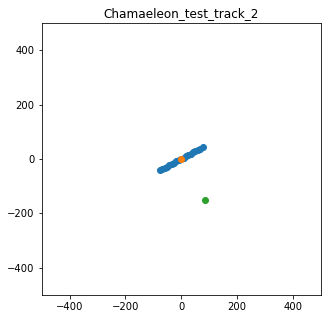

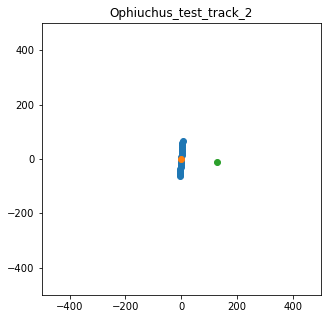

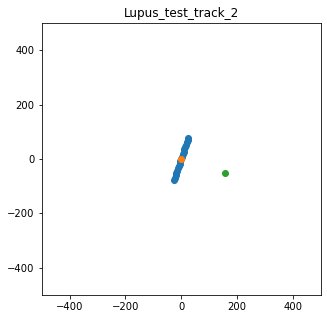

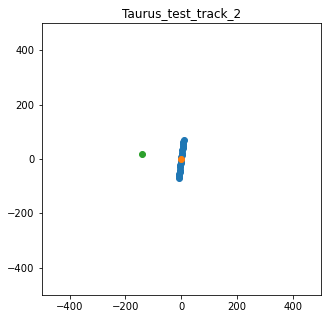

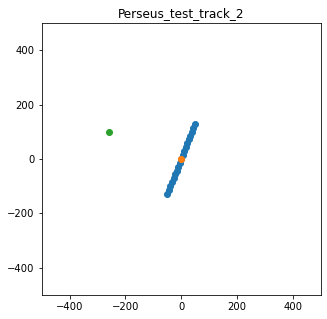

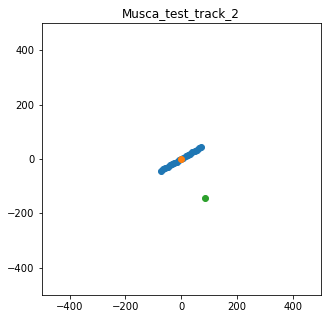

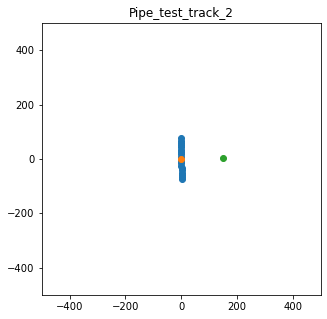

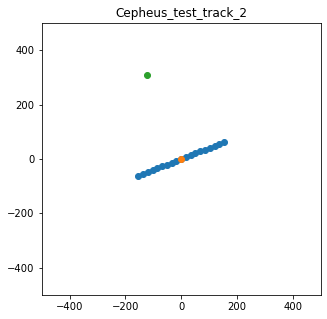

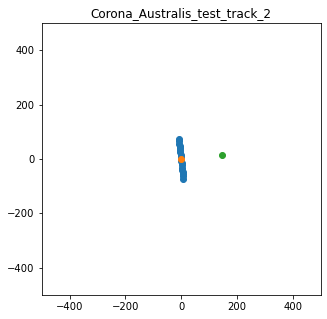

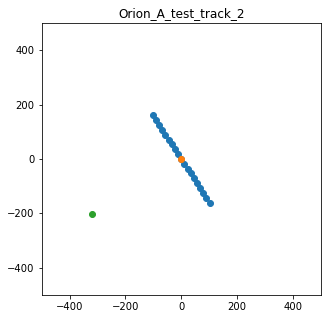

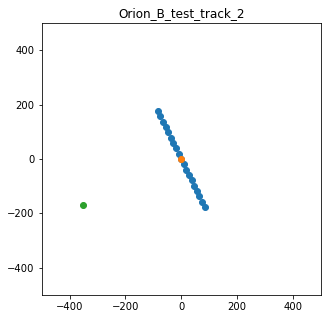

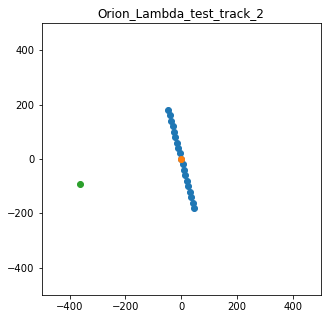

In [15]:
makeimages = True
makemovies = True
oldzeta = 0
for c in clouds:
    print(c['cloud'])
    run_name = c['cloud'] + '_test_track_2'
    define_paths(run_name)
    if arc:
        xs, ys, angs = sweep(c['x'], c['y'], angle_sweep, nframes)
        print(xs, ys, angs)
        plot_ang(c['x'], c['y'], xs, ys, run_name)
        # we make an empty list of frames to which we can append frames
        fprops = []
        allprops = build_fprops(fprops, cprops, angs, xs, ys, np.float(c['z']))
    if not arc:
        #hardcoding a track
        #xts, yts, zts, t_hat = track(c['xt1'], c['yt1'], c['zt1'], c['xt2'], c['yt2'], c['zt2'], nframes)
        xts, yts, zts, t_hat = track(c['y']*0.5, c['x']*(-0.5), 0, c['y']*(-0.5), c['x']*(0.5), 0, nframes)
        plot_track(xts, yts, c['x'], c['y'], run_name)
        print(t_hat)
        fprops = []
        thetas = np.zeros(nframes)
        phis = np.zeros(nframes)
        zetas = np.zeros(nframes)
        for j in np.arange(nframes):
            v_pos = np.array([xts[j], yts[j], zts[j]])
            c_pos = np.array([c['x'], c['y'], c['z']])
            thetas[j], phis[j], zetas[j] = determine_angles(v_pos, c_pos, t_hat)
            print(thetas[j]*180/np.pi, phis[j]*180/np.pi, zetas[j]*180/np.pi,(zetas[j]-oldzeta)*180/np.pi )
            oldzeta = zetas[j]
        allprops = build_fprops_track(fprops, cprops, thetas, phis, zetas, xts, yts, zts)

    with open('{}/{}/{}.json'.format(os.environ['DROPBOX_ROOT'],run_name,run_name), 'w') as outfile:
        json.dump(allprops, outfile,indent=2)
    if makeimages:
        os.system("python3 project_frames.py {}/{}/{}.json {}/leike2020_bayestar19_splice.npy {}/{}/frames/{}_{{:05d}}.png"
          .format(os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],os.environ['DROPBOX_ROOT'],run_name, run_name))
    if makemovies:
        os.system("{}/ffmpeg -y -r 30 -start_number 0 -i {}/{}/frames/{}_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p {}/{}/{}.mp4"
          .format(os.environ['FFMPEG_ROOT'],os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],run_name, run_name))


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

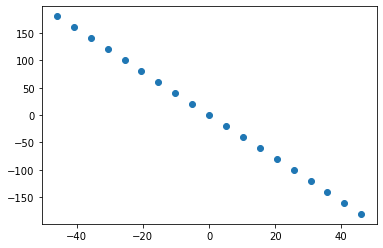

In [16]:
plt.scatter(xts, yts)
plt.scatter()

In [ ]:
print(nframes)